In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline


import xgboost as xgb
import catboost
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB



from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from PIL import Image
import mlflow
import mlflow.sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
import optuna

import joblib
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from mlflow import MlflowClient
import requests


## Table of content
- 1. [COVID-19](#1-covid-19-dataset-)
- 2. [23_end](#pipeline)

## 1. COVID-19 Dataset 



#### COVID-19 patient's symptoms, status, and medical history.

#### About Dataset

This dataset is taken from Kaggle platform (https://www.kaggle.com/datasets/meirnizri/covid19-dataset)  


##### Context  

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

##### content
The dataset was provided by the Mexican government. This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [16]:
# data = pd.read_csv('data/Covid_data.csv')
data = pd.read_csv('data/original/Covid_data_full.csv')

data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [17]:
# data_sl = data.iloc[900000:]
# data_sl

In [18]:
# we use only part of data, other we will use for testing after
data = data.iloc[0:900000]
data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,2,12,1,1,9999-99-99,97,2,52,2,1,...,2,2,1,2,2,2,2,2,7,97
899996,2,12,2,1,9999-99-99,97,2,4,97,2,...,2,2,2,2,2,2,2,2,7,97
899997,2,12,1,1,9999-99-99,97,2,24,2,2,...,2,2,2,2,2,2,2,2,7,97
899998,2,12,1,1,9999-99-99,97,2,22,2,2,...,2,2,2,2,2,2,2,2,7,97


In [19]:
missing_values_count = data.apply(lambda col: col.isin([97, 99]).sum())
missing_values_count

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 714474
PNEUMONIA                15837
AGE                        204
PREGNANT                454131
DIABETES                     0
COPD                         0
ASTHMA                       0
INMSUPR                      0
HIPERTENSION                 0
OTHER_DISEASE                0
CARDIOVASCULAR               0
OBESITY                      0
RENAL_CHRONIC                0
TOBACCO                      0
CLASIFFICATION_FINAL         0
ICU                     714637
dtype: int64

In [20]:
data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

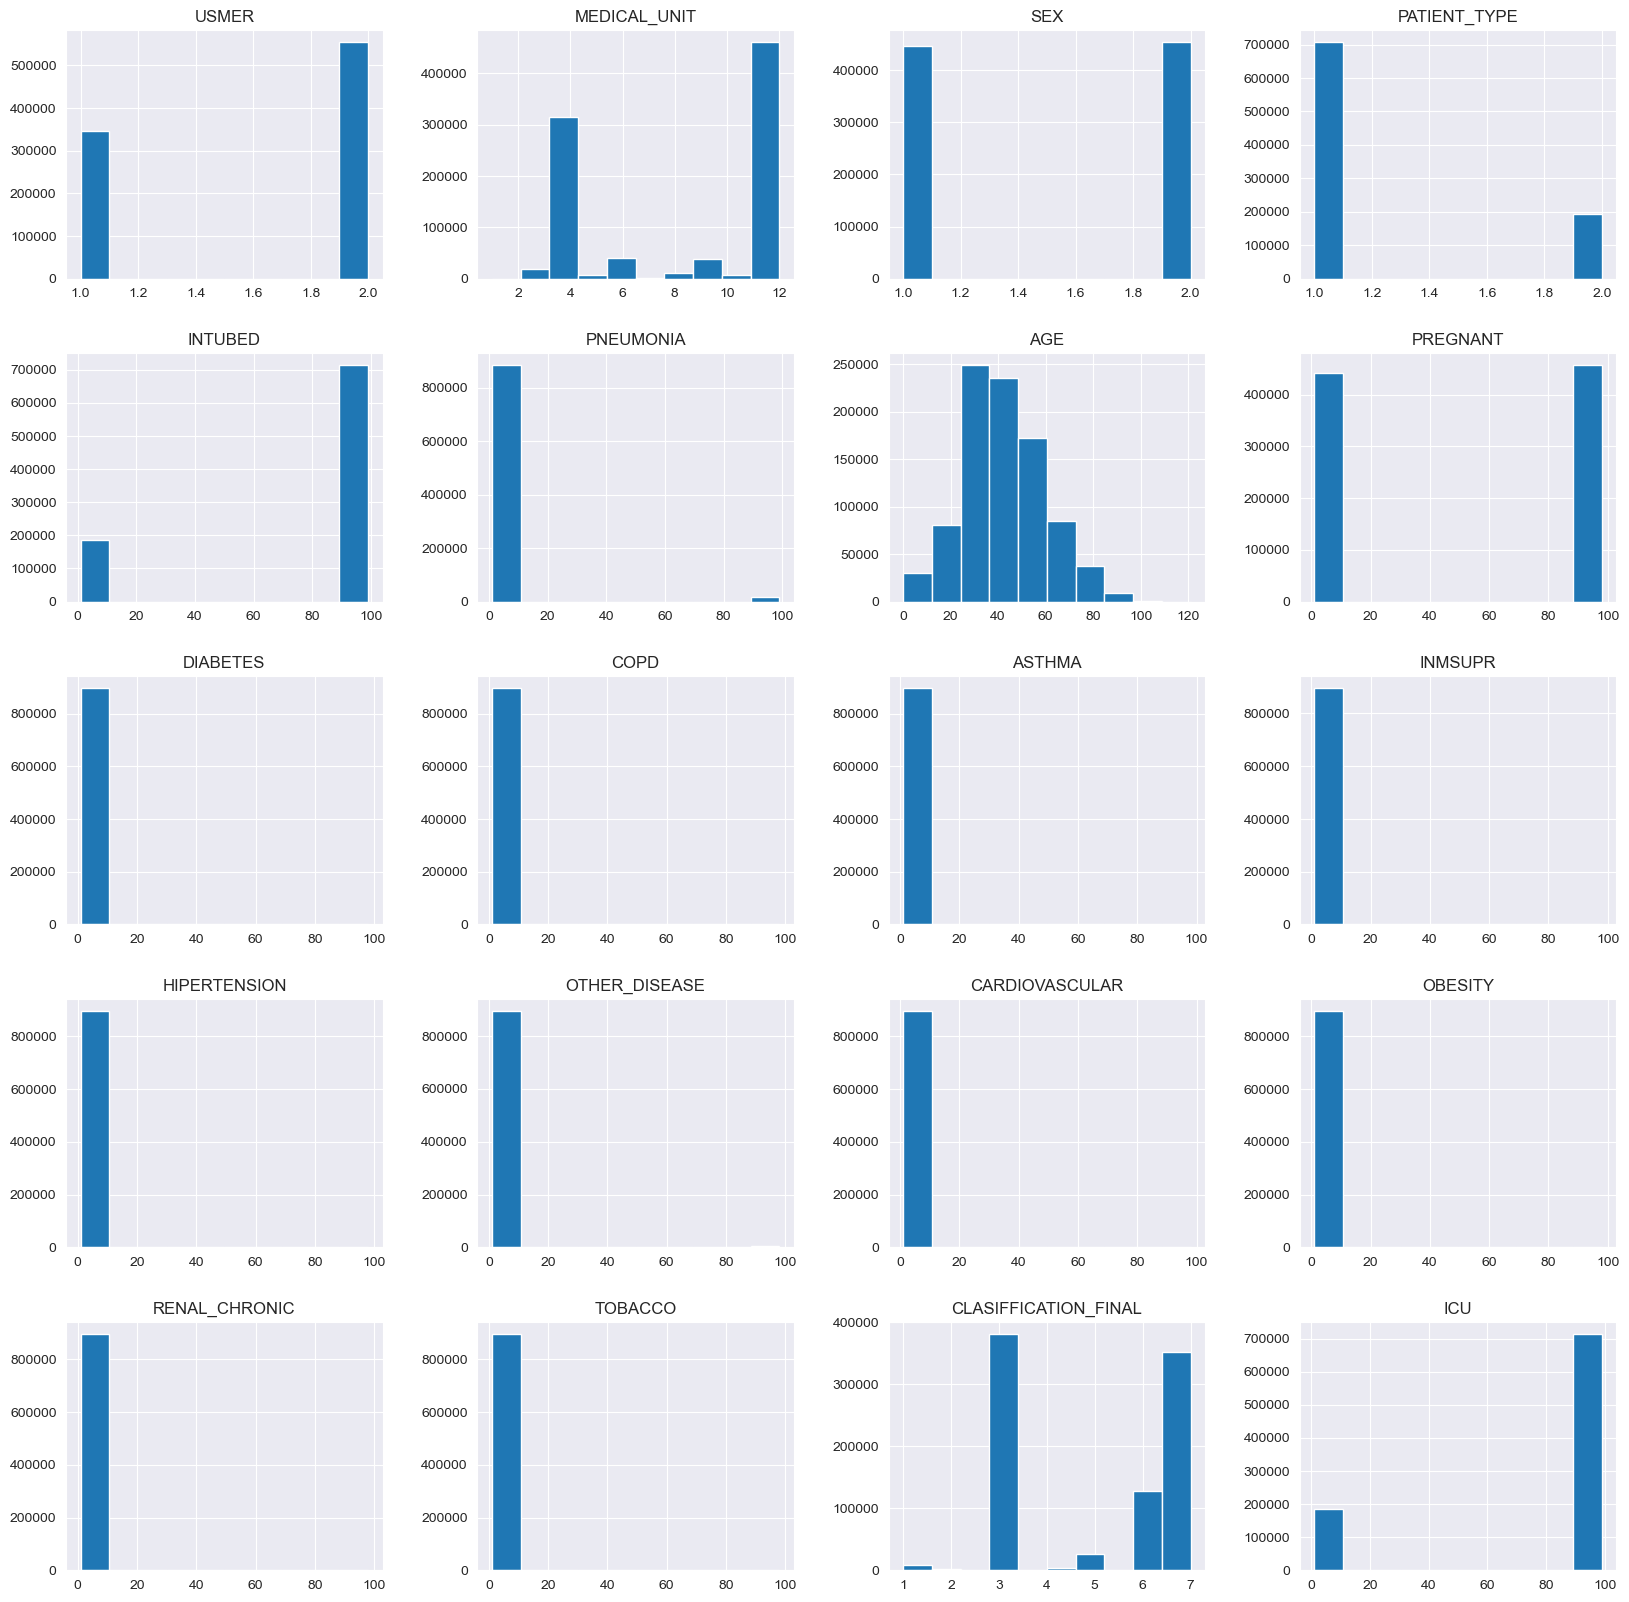

In [21]:
data.hist(figsize=(20, 20));

## 2. Pipeline

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   USMER                 900000 non-null  int64 
 1   MEDICAL_UNIT          900000 non-null  int64 
 2   SEX                   900000 non-null  int64 
 3   PATIENT_TYPE          900000 non-null  int64 
 4   DATE_DIED             900000 non-null  object
 5   INTUBED               900000 non-null  int64 
 6   PNEUMONIA             900000 non-null  int64 
 7   AGE                   900000 non-null  int64 
 8   PREGNANT              900000 non-null  int64 
 9   DIABETES              900000 non-null  int64 
 10  COPD                  900000 non-null  int64 
 11  ASTHMA                900000 non-null  int64 
 12  INMSUPR               900000 non-null  int64 
 13  HIPERTENSION          900000 non-null  int64 
 14  OTHER_DISEASE         900000 non-null  int64 
 15  CARDIOVASCULAR   

In [23]:
# let's make this classification task

data.loc[~data['DATE_DIED'].isin(['9999-99-99']), 'DATE_DIED'] = 1 #checks if the  column is not in the list ['9999-99-99'].
data.loc[data['DATE_DIED'] == '9999-99-99', 'DATE_DIED'] = 0


In [24]:
data['DATE_DIED'].value_counts()

DATE_DIED
0    823119
1     76881
Name: count, dtype: int64

In [153]:
data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,1,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,1,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,1,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,2,12,1,1,0,97,2,52,2,1,...,2,2,1,2,2,2,2,2,7,97
899996,2,12,2,1,0,97,2,4,97,2,...,2,2,2,2,2,2,2,2,7,97
899997,2,12,1,1,0,97,2,24,2,2,...,2,2,2,2,2,2,2,2,7,97
899998,2,12,1,1,0,97,2,22,2,2,...,2,2,2,2,2,2,2,2,7,97


In [25]:
X = data.drop('DATE_DIED',axis=1)
y = data['DATE_DIED']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,train_size=0.7, random_state=13)


In [30]:
# y_test.to_csv('y.csv', index=False)
# X_test.to_csv('X.csv', index=False)

In [169]:
y_train.value_counts()

DATE_DIED
0    576183
1     53817
Name: count, dtype: int64

In [163]:
X_train

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
202828,1,4,2,1,97,2,25,97,2,2,2,2,2,2,2,2,2,2,6,97
821242,2,12,1,1,97,2,29,2,2,2,2,2,2,2,2,2,2,2,7,97
60789,1,4,2,2,2,2,63,97,2,2,2,2,2,2,2,2,2,2,3,2
831707,2,12,2,1,97,2,67,97,2,2,2,2,1,2,2,2,2,1,7,97
524703,2,12,2,1,97,2,40,97,2,2,2,2,2,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892310,2,12,1,1,97,2,4,2,2,2,2,2,2,2,2,2,2,2,7,97
323119,2,4,1,1,97,2,37,2,2,2,2,2,2,2,2,2,2,2,7,97
399457,2,9,2,1,97,2,30,97,2,2,2,2,2,2,2,2,2,2,3,97
295520,1,4,1,1,97,2,29,2,2,2,2,2,2,2,2,2,2,2,7,97


In [168]:
sm=SMOTE()
sm.fit_resample(X_train.reset_index(drop=True),y_train.reset_index(drop=True))

ValueError: Unknown label type: 'unknown'

### Pipeline

In [156]:
numerical_features = ['AGE']

categorical_features = [i for i in X_train.columns if i not in numerical_features]

# numeric data pipeline
pipe_num = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')), # not necessary because we have already clean data 
    ('power_tr', PowerTransformer()),
    ('scaler', StandardScaler()) ])

# cat data pipeline
pipe_cat = Pipeline([
    # ('imputer', SimpleImputer(strategy='constant',fill_value='unknown')), # not necessary because we have already clean data 
    ('encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])

# column transformer
ct = ColumnTransformer([
    ('pipe_num', pipe_num, numerical_features),
    ('pipe_cat', pipe_cat, categorical_features) ])

In [157]:
# pipe_sm = imbpipeline([('smote', SMOTE(random_state=42) )])

numerical_features = ['AGE']

categorical_features = [i for i in X_train.columns if i not in numerical_features]

# numeric data pipeline
pipe_num = imbpipeline([
    # ('imputer', SimpleImputer(strategy='median')), # not necessary because we have already clean data 
    ('power_tr', PowerTransformer()),
    ('scaler', StandardScaler()) ])

# cat data pipeline
pipe_cat = imbpipeline([
    # ('imputer', SimpleImputer(strategy='constant',fill_value='unknown')), # not necessary because we have already clean data 
    ('encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])




# column transformer
ct = ColumnTransformer([
    ('pipe_num', pipe_num, numerical_features),
    ('pipe_cat', pipe_cat, categorical_features),
    ])

pipe = imbpipeline([
    ('pipe_sm', SMOTE(random_state=42) ),
    ('column_transformer', ct),
    ('model', xgb.XGBClassifier())
])


In [158]:
pipe.fit(X_train,y_train)

ValueError: Unknown label type: 'unknown'

In [110]:
pipe.predict(X_test)

AttributeError: 'SMOTE' object has no attribute 'predict'

## 3. Model training

### 3.1 XGBoost model
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [61]:
#full pipeline with XGBoost
pipe = Pipeline([
    ('column_transformer', ct),
    ('model', xgb.XGBClassifier()),  # It denotes the fraction of observations to be randomly samples for each tree. 
])


In [62]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')
client = MlflowClient()
local_dir = ('C:/Users/Peter/DataspellProjects/pollock')


In [63]:
# optimize hyperparameters with Optuna
def objective(trial):

    # params for optimization
    params = {
        'model__eta': trial.suggest_float('model__eta', 0.01, 0.2),
        'model__gamma': trial.suggest_float('model__gamma', 0.01, 5),
        'model__max_depth': trial.suggest_int('model__max_depth', 3, 10),
        'model__min_child_weight': trial.suggest_float('model__min_child_weight', 1, 10),
        'model__max_delta_step': trial.suggest_float('model__max_delta_step', 0.001, 10),
        'model__subsample': trial.suggest_float('model__subsample', 0.1, 1),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.5, 1),
        'model__colsample_bylevel': trial.suggest_float('model__colsample_bylevel', 0.5, 1),
        'model__colsample_bynode': trial.suggest_float('model__colsample_bynode', 0.5, 1),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 1e-5, 1e2),
        'model__reg_alpha': trial.suggest_float('model__reg_alpha', 1e-5, 1e2),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1, 10),
        'model__max_leaves': trial.suggest_int('model__max_leaves', 1, 100),
    }

    pipe.set_params(**params)

    # model fitting
    cross_val_f1 = cross_val_score(pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification


mlflow.set_experiment("MLflow_hype_optuna_XGB")

with mlflow.start_run(run_name='xgb_optuna_run'):
    study = optuna.create_study(direction='maximize')  # Maximize F1 score
    study.optimize(objective, n_trials=10)

    best_trial = study.best_trial
    best_params = best_trial.params

    # Log parameters
    mlflow.log_params(best_params)

    # Set the best parameters to your model
    pipe.set_params(**best_params)

    # Train the model with the best parameters on the entire training set
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)


# Metrics
    accuracy = accuracy_score(list(y_test), y_pred)
    recall = recall_score(list(y_test), y_pred)
    f1 = f1_score(list(y_test), y_pred)

    mlflow.sklearn.log_model(pipe, 'xgb_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr, tpr, thresholds = roc_curve(list(y_test), y_pred)
    roc_auc = roc_auc_score(list(y_test), y_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_plot_path = "mlruns/roc_auc_plot.png"
    plt.savefig(roc_auc_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")


[I 2024-01-15 21:22:09,498] A new study created in memory with name: no-name-d6a9d60e-e455-4fd6-bed7-7658f4480ed6
[W 2024-01-15 21:22:32,915] Trial 0 failed with parameters: {'model__eta': 0.07056942910066455, 'model__gamma': 2.382608971400214, 'model__max_depth': 5, 'model__min_child_weight': 2.238841059744984, 'model__max_delta_step': 3.085451594898586, 'model__subsample': 0.8473445438628768, 'model__colsample_bytree': 0.9586417825444395, 'model__colsample_bylevel': 0.9202822062297726, 'model__colsample_bynode': 0.7246518022866739, 'model__reg_lambda': 58.54589750246274, 'model__reg_alpha': 64.47175082707076, 'model__scale_pos_weight': 8.496748106542212, 'model__max_leaves': 84} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Peter\AppData\Local\Temp\ipykernel_8336\2753971248.py"

KeyboardInterrupt: 

In [32]:
logged_model_xgb = 'runs:/e633976a1fc348e18e50f4411904613f/xgb_model_optuna'

# Load model as a PyFuncModel.
loaded_model_xgb = mlflow.pyfunc.load_model(logged_model_xgb)

In [34]:
joblib.dump(loaded_model_xgb,'model_xgb.joblib')

['model_xgb.joblib']

### 3.2 CatBoost model
Catboost is a boosted decision tree machine learning algorithm developed by Yandex. It works in the same way as other gradient boosted algorithms such as XGBoost but provides support out of the box for categorical variables, has a higher level of accuracy without tuning parameters and also offers GPU support to speed up training.


In [17]:
# Full pipeline with CatBoost
cat_pipe = Pipeline([
    ('column_transformer', ct),
    ('model', CatBoostClassifier()),  # Use CatBoostClassifier
])

In [18]:
# Optimize hyperparameters with Optuna
def objective(trial):

    # Parameters for optimization
    cat_params = {
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 0.2),
        'model__depth': trial.suggest_int('model__depth', 3, 10),
        'model__l2_leaf_reg': trial.suggest_float('model__l2_leaf_reg', 1, 10),
        'model__subsample': trial.suggest_float('model__subsample', 0.1, 1),
        'model__colsample_bylevel': trial.suggest_float('model__colsample_bylevel', 0.5, 1),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1, 10),
    }

    cat_pipe.set_params(**cat_params)

    # Model fitting
    cross_val_f1 = cross_val_score(cat_pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification

mlflow.set_experiment("MLflow_hype_optuna_CatBoost")

with mlflow.start_run(run_name='catboost_optuna_run'):
    cat_study = optuna.create_study(direction='maximize')  # Maximize F1 score
    cat_study.optimize(objective, n_trials=10)

    best_cat_trial = cat_study.best_trial
    best_cat_params = best_cat_trial.params

    # Log parameters
    mlflow.log_params(best_cat_params)

    # Set the best parameters to your CatBoost model
    cat_pipe.set_params(**best_cat_params)

    # Train the model with the best parameters on the entire training set
    cat_pipe.fit(X_train, y_train)

    # Make predictions on the test set
    y_cat_pred = cat_pipe.predict(X_test)

    # Metrics
    accuracy_cat = accuracy_score(list(y_test), y_cat_pred)
    recall_cat = recall_score(list(y_test), y_cat_pred)
    f1_cat = f1_score(list(y_test), y_cat_pred)

    mlflow.sklearn.log_model(cat_pipe, 'catboost_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_cat,
        'recall': recall_cat,
        'f1_score': f1_cat,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr_cat, tpr_cat, thresholds_cat = roc_curve(list(y_test), y_cat_pred)
    roc_auc_cat = roc_auc_score(list(y_test), y_cat_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cat))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_cat_plot_path = "mlruns/roc_auc_cat_plot.png"
    plt.savefig(roc_auc_cat_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_cat_plot_path, "roc_auc_cat_plot")

[I 2024-01-12 01:58:59,617] A new study created in memory with name: no-name-c2e0a39d-4f7f-4c71-8b57-6f6d3d9d9bb2


0:	learn: 0.4288916	total: 216ms	remaining: 3m 35s
1:	learn: 0.3200828	total: 288ms	remaining: 2m 23s
2:	learn: 0.2655653	total: 360ms	remaining: 1m 59s
3:	learn: 0.2394070	total: 436ms	remaining: 1m 48s
4:	learn: 0.2256130	total: 529ms	remaining: 1m 45s
5:	learn: 0.2177623	total: 617ms	remaining: 1m 42s
6:	learn: 0.2132401	total: 718ms	remaining: 1m 41s
7:	learn: 0.2098297	total: 791ms	remaining: 1m 38s
8:	learn: 0.2079507	total: 868ms	remaining: 1m 35s
9:	learn: 0.2064973	total: 942ms	remaining: 1m 33s
10:	learn: 0.2049670	total: 1.03s	remaining: 1m 32s
11:	learn: 0.2040374	total: 1.1s	remaining: 1m 30s
12:	learn: 0.2031536	total: 1.18s	remaining: 1m 29s
13:	learn: 0.2023432	total: 1.25s	remaining: 1m 28s
14:	learn: 0.2015479	total: 1.34s	remaining: 1m 27s
15:	learn: 0.2009890	total: 1.42s	remaining: 1m 27s
16:	learn: 0.2006444	total: 1.51s	remaining: 1m 27s
17:	learn: 0.2001991	total: 1.59s	remaining: 1m 26s
18:	learn: 0.1998910	total: 1.67s	remaining: 1m 26s
19:	learn: 0.1992978	to

[I 2024-01-12 02:07:15,977] Trial 0 finished with value: 0.6381162114524498 and parameters: {'model__learning_rate': 0.19445768968889457, 'model__depth': 10, 'model__l2_leaf_reg': 6.058590820838887, 'model__subsample': 0.7792358784689692, 'model__colsample_bylevel': 0.5962387938705593, 'model__scale_pos_weight': 3.306560291849736}. Best is trial 0 with value: 0.6381162114524498.


0:	learn: 0.5967622	total: 39.5ms	remaining: 39.4s
1:	learn: 0.5114451	total: 72.5ms	remaining: 36.2s
2:	learn: 0.4515735	total: 107ms	remaining: 35.4s
3:	learn: 0.4076588	total: 145ms	remaining: 36.1s
4:	learn: 0.3750773	total: 181ms	remaining: 36.1s
5:	learn: 0.3495618	total: 233ms	remaining: 38.6s
6:	learn: 0.3307915	total: 276ms	remaining: 39.1s
7:	learn: 0.3153911	total: 323ms	remaining: 40s
8:	learn: 0.3059152	total: 371ms	remaining: 40.8s
9:	learn: 0.2977094	total: 418ms	remaining: 41.3s
10:	learn: 0.2904868	total: 479ms	remaining: 43.1s
11:	learn: 0.2847394	total: 527ms	remaining: 43.4s
12:	learn: 0.2805668	total: 571ms	remaining: 43.3s
13:	learn: 0.2762605	total: 609ms	remaining: 42.9s
14:	learn: 0.2728366	total: 644ms	remaining: 42.3s
15:	learn: 0.2695305	total: 683ms	remaining: 42s
16:	learn: 0.2667220	total: 722ms	remaining: 41.8s
17:	learn: 0.2643849	total: 762ms	remaining: 41.6s
18:	learn: 0.2628486	total: 802ms	remaining: 41.4s
19:	learn: 0.2607779	total: 845ms	remaining

[I 2024-01-12 02:11:36,295] Trial 1 finished with value: 0.591885465079676 and parameters: {'model__learning_rate': 0.09579634344775252, 'model__depth': 4, 'model__l2_leaf_reg': 7.622597078061225, 'model__subsample': 0.9159439524614832, 'model__colsample_bylevel': 0.7818798947343174, 'model__scale_pos_weight': 9.108885147403711}. Best is trial 0 with value: 0.6381162114524498.


0:	learn: 0.5705090	total: 42.6ms	remaining: 42.6s
1:	learn: 0.4845323	total: 83.4ms	remaining: 41.6s
2:	learn: 0.4180624	total: 123ms	remaining: 40.7s
3:	learn: 0.3756758	total: 162ms	remaining: 40.5s
4:	learn: 0.3451274	total: 204ms	remaining: 40.5s
5:	learn: 0.3216053	total: 249ms	remaining: 41.2s
6:	learn: 0.3022024	total: 296ms	remaining: 42s
7:	learn: 0.2882318	total: 351ms	remaining: 43.5s
8:	learn: 0.2772821	total: 393ms	remaining: 43.3s
9:	learn: 0.2688391	total: 439ms	remaining: 43.4s
10:	learn: 0.2627059	total: 486ms	remaining: 43.7s
11:	learn: 0.2572477	total: 538ms	remaining: 44.3s
12:	learn: 0.2535931	total: 582ms	remaining: 44.2s
13:	learn: 0.2498845	total: 626ms	remaining: 44.1s
14:	learn: 0.2469831	total: 674ms	remaining: 44.2s
15:	learn: 0.2445409	total: 722ms	remaining: 44.4s
16:	learn: 0.2427409	total: 778ms	remaining: 45s
17:	learn: 0.2412365	total: 829ms	remaining: 45.2s
18:	learn: 0.2397635	total: 877ms	remaining: 45.3s
19:	learn: 0.2387869	total: 923ms	remaining

[I 2024-01-12 02:16:20,821] Trial 2 finished with value: 0.6149802118632127 and parameters: {'model__learning_rate': 0.09295139816940387, 'model__depth': 8, 'model__l2_leaf_reg': 3.077291183306999, 'model__subsample': 0.17125584482450834, 'model__colsample_bylevel': 0.5852592731818325, 'model__scale_pos_weight': 6.233877784307359}. Best is trial 0 with value: 0.6381162114524498.


0:	learn: 0.6536048	total: 33.1ms	remaining: 33.1s
1:	learn: 0.6172355	total: 66.2ms	remaining: 33s
2:	learn: 0.5835630	total: 98.3ms	remaining: 32.7s
3:	learn: 0.5531000	total: 132ms	remaining: 32.9s
4:	learn: 0.5241271	total: 168ms	remaining: 33.4s
5:	learn: 0.4976186	total: 203ms	remaining: 33.7s
6:	learn: 0.4741799	total: 240ms	remaining: 34.1s
7:	learn: 0.4529751	total: 281ms	remaining: 34.8s
8:	learn: 0.4331350	total: 326ms	remaining: 36s
9:	learn: 0.4153630	total: 363ms	remaining: 35.9s
10:	learn: 0.3993140	total: 397ms	remaining: 35.7s
11:	learn: 0.3849370	total: 439ms	remaining: 36.1s
12:	learn: 0.3713399	total: 482ms	remaining: 36.6s
13:	learn: 0.3590763	total: 529ms	remaining: 37.3s
14:	learn: 0.3478959	total: 568ms	remaining: 37.3s
15:	learn: 0.3377191	total: 603ms	remaining: 37.1s
16:	learn: 0.3284847	total: 641ms	remaining: 37.1s
17:	learn: 0.3203001	total: 681ms	remaining: 37.1s
18:	learn: 0.3127036	total: 723ms	remaining: 37.4s
19:	learn: 0.3059158	total: 770ms	remainin

[I 2024-01-12 02:20:37,212] Trial 3 finished with value: 0.6519980263015948 and parameters: {'model__learning_rate': 0.024416311675826807, 'model__depth': 5, 'model__l2_leaf_reg': 9.045428872636466, 'model__subsample': 0.5337136228917895, 'model__colsample_bylevel': 0.9038683628585817, 'model__scale_pos_weight': 2.999089008497236}. Best is trial 3 with value: 0.6519980263015948.


0:	learn: 0.6000735	total: 47.7ms	remaining: 47.7s
1:	learn: 0.5239286	total: 120ms	remaining: 59.7s
2:	learn: 0.4638493	total: 188ms	remaining: 1m 2s
3:	learn: 0.4158378	total: 268ms	remaining: 1m 6s
4:	learn: 0.3787742	total: 350ms	remaining: 1m 9s
5:	learn: 0.3493088	total: 427ms	remaining: 1m 10s
6:	learn: 0.3269912	total: 499ms	remaining: 1m 10s
7:	learn: 0.3091269	total: 575ms	remaining: 1m 11s
8:	learn: 0.2945693	total: 650ms	remaining: 1m 11s
9:	learn: 0.2827608	total: 723ms	remaining: 1m 11s
10:	learn: 0.2727146	total: 800ms	remaining: 1m 11s
11:	learn: 0.2647454	total: 874ms	remaining: 1m 11s
12:	learn: 0.2580325	total: 956ms	remaining: 1m 12s
13:	learn: 0.2525461	total: 1.03s	remaining: 1m 12s
14:	learn: 0.2480434	total: 1.11s	remaining: 1m 12s
15:	learn: 0.2443249	total: 1.19s	remaining: 1m 13s
16:	learn: 0.2411044	total: 1.27s	remaining: 1m 13s
17:	learn: 0.2382332	total: 1.35s	remaining: 1m 13s
18:	learn: 0.2359212	total: 1.43s	remaining: 1m 13s
19:	learn: 0.2340572	total

[I 2024-01-12 02:27:58,324] Trial 4 finished with value: 0.6329729787530134 and parameters: {'model__learning_rate': 0.06405347155442806, 'model__depth': 10, 'model__l2_leaf_reg': 1.9452046692531912, 'model__subsample': 0.5792532701443656, 'model__colsample_bylevel': 0.6622288599278192, 'model__scale_pos_weight': 4.619963481425737}. Best is trial 3 with value: 0.6519980263015948.


0:	learn: 0.6723174	total: 76.3ms	remaining: 1m 16s
1:	learn: 0.6520202	total: 149ms	remaining: 1m 14s
2:	learn: 0.6328115	total: 226ms	remaining: 1m 15s
3:	learn: 0.6145333	total: 308ms	remaining: 1m 16s
4:	learn: 0.5967049	total: 391ms	remaining: 1m 17s
5:	learn: 0.5804479	total: 477ms	remaining: 1m 19s
6:	learn: 0.5644831	total: 563ms	remaining: 1m 19s
7:	learn: 0.5487160	total: 651ms	remaining: 1m 20s
8:	learn: 0.5343906	total: 735ms	remaining: 1m 20s
9:	learn: 0.5208949	total: 823ms	remaining: 1m 21s
10:	learn: 0.5076735	total: 916ms	remaining: 1m 22s
11:	learn: 0.4948140	total: 1.01s	remaining: 1m 22s
12:	learn: 0.4828314	total: 1.11s	remaining: 1m 23s
13:	learn: 0.4713583	total: 1.2s	remaining: 1m 24s
14:	learn: 0.4603859	total: 1.29s	remaining: 1m 24s
15:	learn: 0.4503842	total: 1.38s	remaining: 1m 24s
16:	learn: 0.4404181	total: 1.47s	remaining: 1m 24s
17:	learn: 0.4316015	total: 1.55s	remaining: 1m 24s
18:	learn: 0.4228213	total: 1.64s	remaining: 1m 24s
19:	learn: 0.4140375	t

[I 2024-01-12 02:36:05,336] Trial 5 finished with value: 0.6336621112506368 and parameters: {'model__learning_rate': 0.012897058041508272, 'model__depth': 10, 'model__l2_leaf_reg': 4.730190038827303, 'model__subsample': 0.9349906932430162, 'model__colsample_bylevel': 0.6544470654314587, 'model__scale_pos_weight': 4.447425115708542}. Best is trial 3 with value: 0.6519980263015948.


0:	learn: 0.6545570	total: 48ms	remaining: 48s
1:	learn: 0.6178844	total: 118ms	remaining: 59s
2:	learn: 0.5837765	total: 189ms	remaining: 1m 2s
3:	learn: 0.5524704	total: 256ms	remaining: 1m 3s
4:	learn: 0.5250920	total: 333ms	remaining: 1m 6s
5:	learn: 0.5006315	total: 404ms	remaining: 1m 6s
6:	learn: 0.4771711	total: 475ms	remaining: 1m 7s
7:	learn: 0.4562095	total: 551ms	remaining: 1m 8s
8:	learn: 0.4376692	total: 630ms	remaining: 1m 9s
9:	learn: 0.4207734	total: 706ms	remaining: 1m 9s
10:	learn: 0.4055394	total: 783ms	remaining: 1m 10s
11:	learn: 0.3909663	total: 868ms	remaining: 1m 11s
12:	learn: 0.3780372	total: 949ms	remaining: 1m 12s
13:	learn: 0.3662507	total: 1.03s	remaining: 1m 12s
14:	learn: 0.3551171	total: 1.11s	remaining: 1m 13s
15:	learn: 0.3452805	total: 1.2s	remaining: 1m 13s
16:	learn: 0.3365172	total: 1.28s	remaining: 1m 13s
17:	learn: 0.3282910	total: 1.36s	remaining: 1m 14s
18:	learn: 0.3212287	total: 1.44s	remaining: 1m 14s
19:	learn: 0.3145513	total: 1.51s	rema

[I 2024-01-12 02:43:28,781] Trial 6 finished with value: 0.6253943331798195 and parameters: {'model__learning_rate': 0.02621039063195136, 'model__depth': 10, 'model__l2_leaf_reg': 9.580102326767937, 'model__subsample': 0.6194841083387542, 'model__colsample_bylevel': 0.8277049867649986, 'model__scale_pos_weight': 5.190446988804192}. Best is trial 3 with value: 0.6519980263015948.


0:	learn: 0.6129952	total: 50.3ms	remaining: 50.3s
1:	learn: 0.5440800	total: 101ms	remaining: 50.4s
2:	learn: 0.4840583	total: 150ms	remaining: 49.9s
3:	learn: 0.4372731	total: 197ms	remaining: 49.2s
4:	learn: 0.3963288	total: 247ms	remaining: 49.2s
5:	learn: 0.3634151	total: 310ms	remaining: 51.4s
6:	learn: 0.3351828	total: 362ms	remaining: 51.3s
7:	learn: 0.3116978	total: 412ms	remaining: 51.1s
8:	learn: 0.2908194	total: 460ms	remaining: 50.7s
9:	learn: 0.2746482	total: 508ms	remaining: 50.3s
10:	learn: 0.2608895	total: 559ms	remaining: 50.3s
11:	learn: 0.2490815	total: 614ms	remaining: 50.5s
12:	learn: 0.2390016	total: 669ms	remaining: 50.8s
13:	learn: 0.2307611	total: 726ms	remaining: 51.1s
14:	learn: 0.2240275	total: 782ms	remaining: 51.4s
15:	learn: 0.2176781	total: 843ms	remaining: 51.8s
16:	learn: 0.2119714	total: 896ms	remaining: 51.8s
17:	learn: 0.2078260	total: 953ms	remaining: 52s
18:	learn: 0.2033845	total: 1.01s	remaining: 52s
19:	learn: 0.1993469	total: 1.07s	remaining:

[I 2024-01-12 02:48:51,647] Trial 7 finished with value: 0.6596229382167815 and parameters: {'model__learning_rate': 0.04037778937127749, 'model__depth': 8, 'model__l2_leaf_reg': 4.663845169695502, 'model__subsample': 0.8245877146952949, 'model__colsample_bylevel': 0.7358165474397247, 'model__scale_pos_weight': 1.7164316415350531}. Best is trial 7 with value: 0.6596229382167815.


0:	learn: 0.5066275	total: 46.7ms	remaining: 46.7s
1:	learn: 0.4000374	total: 92ms	remaining: 45.9s
2:	learn: 0.3382520	total: 139ms	remaining: 46.2s
3:	learn: 0.3013998	total: 187ms	remaining: 46.5s
4:	learn: 0.2809721	total: 232ms	remaining: 46.2s
5:	learn: 0.2684433	total: 282ms	remaining: 46.6s
6:	learn: 0.2590724	total: 340ms	remaining: 48.2s
7:	learn: 0.2523968	total: 389ms	remaining: 48.3s
8:	learn: 0.2482810	total: 440ms	remaining: 48.5s
9:	learn: 0.2451704	total: 488ms	remaining: 48.3s
10:	learn: 0.2429258	total: 544ms	remaining: 48.9s
11:	learn: 0.2412134	total: 596ms	remaining: 49.1s
12:	learn: 0.2394038	total: 646ms	remaining: 49s
13:	learn: 0.2379413	total: 698ms	remaining: 49.1s
14:	learn: 0.2369911	total: 748ms	remaining: 49.1s
15:	learn: 0.2360458	total: 799ms	remaining: 49.1s
16:	learn: 0.2353030	total: 860ms	remaining: 49.7s
17:	learn: 0.2345000	total: 917ms	remaining: 50s
18:	learn: 0.2335340	total: 977ms	remaining: 50.4s
19:	learn: 0.2329711	total: 1.03s	remaining: 

[I 2024-01-12 02:54:08,003] Trial 8 finished with value: 0.6063498111892212 and parameters: {'model__learning_rate': 0.16339248057988476, 'model__depth': 8, 'model__l2_leaf_reg': 8.067749248200418, 'model__subsample': 0.7776721237497753, 'model__colsample_bylevel': 0.989438546236608, 'model__scale_pos_weight': 7.640058546774842}. Best is trial 7 with value: 0.6596229382167815.


0:	learn: 0.5655050	total: 71.7ms	remaining: 1m 11s
1:	learn: 0.4817031	total: 120ms	remaining: 1m
2:	learn: 0.4133033	total: 191ms	remaining: 1m 3s
3:	learn: 0.3670773	total: 263ms	remaining: 1m 5s
4:	learn: 0.3341565	total: 346ms	remaining: 1m 8s
5:	learn: 0.3099421	total: 417ms	remaining: 1m 9s
6:	learn: 0.2941486	total: 492ms	remaining: 1m 9s
7:	learn: 0.2805255	total: 574ms	remaining: 1m 11s
8:	learn: 0.2705037	total: 652ms	remaining: 1m 11s
9:	learn: 0.2628638	total: 729ms	remaining: 1m 12s
10:	learn: 0.2564448	total: 811ms	remaining: 1m 12s
11:	learn: 0.2517143	total: 893ms	remaining: 1m 13s
12:	learn: 0.2480454	total: 975ms	remaining: 1m 14s
13:	learn: 0.2447410	total: 1.07s	remaining: 1m 15s
14:	learn: 0.2426288	total: 1.15s	remaining: 1m 15s
15:	learn: 0.2401968	total: 1.23s	remaining: 1m 15s
16:	learn: 0.2380710	total: 1.31s	remaining: 1m 16s
17:	learn: 0.2366433	total: 1.4s	remaining: 1m 16s
18:	learn: 0.2352870	total: 1.48s	remaining: 1m 16s
19:	learn: 0.2343471	total: 1.5

[I 2024-01-12 03:01:47,144] Trial 9 finished with value: 0.6164074552688177 and parameters: {'model__learning_rate': 0.09461095875506385, 'model__depth': 10, 'model__l2_leaf_reg': 1.7277813958296435, 'model__subsample': 0.734959141405907, 'model__colsample_bylevel': 0.6074008326446535, 'model__scale_pos_weight': 6.46396088954502}. Best is trial 7 with value: 0.6596229382167815.


0:	learn: 0.6130768	total: 58.8ms	remaining: 58.8s
1:	learn: 0.5444123	total: 117ms	remaining: 58.6s
2:	learn: 0.4844658	total: 191ms	remaining: 1m 3s
3:	learn: 0.4376589	total: 248ms	remaining: 1m 1s
4:	learn: 0.3971293	total: 315ms	remaining: 1m 2s
5:	learn: 0.3640980	total: 377ms	remaining: 1m 2s
6:	learn: 0.3356641	total: 439ms	remaining: 1m 2s
7:	learn: 0.3112231	total: 502ms	remaining: 1m 2s
8:	learn: 0.2911292	total: 574ms	remaining: 1m 3s
9:	learn: 0.2748337	total: 641ms	remaining: 1m 3s
10:	learn: 0.2605486	total: 707ms	remaining: 1m 3s
11:	learn: 0.2487640	total: 769ms	remaining: 1m 3s
12:	learn: 0.2383184	total: 848ms	remaining: 1m 4s
13:	learn: 0.2298296	total: 927ms	remaining: 1m 5s
14:	learn: 0.2225015	total: 992ms	remaining: 1m 5s
15:	learn: 0.2164871	total: 1.06s	remaining: 1m 4s
16:	learn: 0.2111604	total: 1.13s	remaining: 1m 5s
17:	learn: 0.2063891	total: 1.19s	remaining: 1m 5s
18:	learn: 0.2022440	total: 1.26s	remaining: 1m 4s
19:	learn: 0.1983933	total: 1.32s	remain

C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [36]:
logged_model_catb = 'runs:/40e5406806ce4b439e31c471d902ac54/catboost_model_optuna'

# Load model as a PyFuncModel.
loaded_model_catb = mlflow.pyfunc.load_model(logged_model_catb)

In [37]:
joblib.dump(loaded_model_catb,'model_catb.joblib')

['model_catb.joblib']

### 3.3 LightGBM model
Light GBM is a gradient boosting framework that uses tree based learning algorithm.

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

In [19]:
# Full pipeline with LightGBM
lgbm_pipe = Pipeline([
    ('column_transformer', ct),
    ('model', LGBMClassifier()),  # Use LGBMClassifier
])

# Optimize hyperparameters with Optuna
def objective(trial):

    # Parameters for optimization
    lgbm_params = {
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 0.2),
        'model__num_leaves': trial.suggest_int('model__num_leaves', 10, 200),
        'model__max_depth': trial.suggest_int('model__max_depth', 3, 20),
        'model__min_child_samples': trial.suggest_int('model__min_child_samples', 1, 20),
        'model__subsample': trial.suggest_float('model__subsample', 0.1, 1),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.5, 1),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 1e-5, 1e2),
        'model__reg_alpha': trial.suggest_float('model__reg_alpha', 1e-5, 1e2),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1, 10),
    }

    lgbm_pipe.set_params(**lgbm_params)

    # Model fitting
    cross_val_f1 = cross_val_score(lgbm_pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification

mlflow.set_experiment("MLflow_hype_optuna_LightGBM")

with mlflow.start_run(run_name='lgbm_optuna_run'):
    lgbm_study = optuna.create_study(direction='maximize')  # Maximize F1 score
    lgbm_study.optimize(objective, n_trials=10)

    best_lgbm_trial = lgbm_study.best_trial
    best_lgbm_params = best_lgbm_trial.params

    # Log parameters
    mlflow.log_params(best_lgbm_params)

    # Set the best parameters to your LightGBM model
    lgbm_pipe.set_params(**best_lgbm_params)

    # Train the model with the best parameters on the entire training set
    lgbm_pipe.fit(X_train, list(y_train))

    # Make predictions on the test set
    y_lgbm_pred = lgbm_pipe.predict(X_test)

    # Metrics
    accuracy_lgbm = accuracy_score(list(y_test), y_lgbm_pred)
    recall_lgbm = recall_score(list(y_test), y_lgbm_pred)
    f1_lgbm = f1_score(list(y_test), y_lgbm_pred)

    mlflow.sklearn.log_model(lgbm_pipe, 'lgbm_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_lgbm,
        'recall': recall_lgbm,
        'f1_score': f1_lgbm,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(list(y_test), y_lgbm_pred)
    roc_auc_lgbm = roc_auc_score(list(y_test), y_lgbm_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_lgbm))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_lgbm_plot_path = "mlruns/roc_auc_lgbm_plot.png"
    plt.savefig(roc_auc_lgbm_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_lgbm_plot_path, "roc_auc_lgbm_plot")

[I 2024-01-12 03:03:10,324] A new study created in memory with name: no-name-ae78504d-1ed2-4cc7-b10f-a5d13864af21


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:03:27,634] Trial 0 finished with value: 0.656091039334854 and parameters: {'model__learning_rate': 0.1142847780370815, 'model__num_leaves': 179, 'model__max_depth': 7, 'model__min_child_samples': 8, 'model__subsample': 0.20146268599727632, 'model__colsample_bytree': 0.6811552763528841, 'model__reg_lambda': 37.60495904642653, 'model__reg_alpha': 58.85276690828287, 'model__scale_pos_weight': 2.3897217200486023}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info

[I 2024-01-12 03:03:44,406] Trial 1 finished with value: 0.6311886121049872 and parameters: {'model__learning_rate': 0.1319476294154538, 'model__num_leaves': 22, 'model__max_depth': 15, 'model__min_child_samples': 15, 'model__subsample': 0.7504557678727787, 'model__colsample_bytree': 0.9306983589670844, 'model__reg_lambda': 49.36705647842995, 'model__reg_alpha': 30.46982521422118, 'model__scale_pos_weight': 4.141970742281305}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:04:03,498] Trial 2 finished with value: 0.6343007644425113 and parameters: {'model__learning_rate': 0.10808382813587185, 'model__num_leaves': 122, 'model__max_depth': 10, 'model__min_child_samples': 4, 'model__subsample': 0.8376350554475243, 'model__colsample_bytree': 0.8822153082323596, 'model__reg_lambda': 90.70042429353204, 'model__reg_alpha': 39.2355682367779, 'model__scale_pos_weight': 3.9558865990314835}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:04:19,074] Trial 3 finished with value: 0.6337858725476438 and parameters: {'model__learning_rate': 0.1997581667779877, 'model__num_leaves': 45, 'model__max_depth': 5, 'model__min_child_samples': 6, 'model__subsample': 0.3726778633632609, 'model__colsample_bytree': 0.541019544842132, 'model__reg_lambda': 43.2271176177091, 'model__reg_alpha': 8.665163407778234, 'model__scale_pos_weight': 4.082250632744129}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:04:36,484] Trial 4 finished with value: 0.6439911777134226 and parameters: {'model__learning_rate': 0.02039849893726301, 'model__num_leaves': 119, 'model__max_depth': 8, 'model__min_child_samples': 6, 'model__subsample': 0.1500011595828185, 'model__colsample_bytree': 0.7610166226907658, 'model__reg_lambda': 95.73259005059488, 'model__reg_alpha': 54.16550990459791, 'model__scale_pos_weight': 2.288123523441663}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:04:54,750] Trial 5 finished with value: 0.5837089970777257 and parameters: {'model__learning_rate': 0.1440236181008272, 'model__num_leaves': 39, 'model__max_depth': 14, 'model__min_child_samples': 7, 'model__subsample': 0.7984382647289534, 'model__colsample_bytree': 0.5232084917600889, 'model__reg_lambda': 15.416929138730517, 'model__reg_alpha': 36.40017015449508, 'model__scale_pos_weight': 9.915948176358174}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data po

[I 2024-01-12 03:05:14,343] Trial 6 finished with value: 0.6330996776903661 and parameters: {'model__learning_rate': 0.05218232405242112, 'model__num_leaves': 92, 'model__max_depth': 9, 'model__min_child_samples': 13, 'model__subsample': 0.721244471599786, 'model__colsample_bytree': 0.7798529387338371, 'model__reg_lambda': 7.371138930545726, 'model__reg_alpha': 0.9819090005406554, 'model__scale_pos_weight': 3.9989297374851165}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:05:35,545] Trial 7 finished with value: 0.5977369719965843 and parameters: {'model__learning_rate': 0.12030422028896066, 'model__num_leaves': 192, 'model__max_depth': 18, 'model__min_child_samples': 10, 'model__subsample': 0.5160434870364997, 'model__colsample_bytree': 0.509005279569692, 'model__reg_lambda': 39.10379825363772, 'model__reg_alpha': 19.863627495201673, 'model__scale_pos_weight': 7.759120822721359}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:05:53,513] Trial 8 finished with value: 0.6240493731877896 and parameters: {'model__learning_rate': 0.14537618007509984, 'model__num_leaves': 82, 'model__max_depth': 19, 'model__min_child_samples': 16, 'model__subsample': 0.9349082861902356, 'model__colsample_bytree': 0.6122926768732017, 'model__reg_lambda': 56.01846213460634, 'model__reg_alpha': 82.84892251486524, 'model__scale_pos_weight': 4.661469646809757}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 43054, number of negative: 460946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085425 -> initscore=-2.370826
[LightGBM] [Info] Start training from score -2.370826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-12 03:06:10,331] Trial 9 finished with value: 0.6432072567410584 and parameters: {'model__learning_rate': 0.15529836702710542, 'model__num_leaves': 46, 'model__max_depth': 10, 'model__min_child_samples': 19, 'model__subsample': 0.7385455504476431, 'model__colsample_bytree': 0.8925733719962478, 'model__reg_lambda': 71.69186878258267, 'model__reg_alpha': 90.28664085264734, 'model__scale_pos_weight': 1.36393090082702}. Best is trial 0 with value: 0.656091039334854.


[LightGBM] [Info] Number of positive: 53817, number of negative: 576183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085424 -> initscore=-2.370836
[LightGBM] [Info] Start training from score -2.370836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [38]:
logged_model_lgbm = logged_model = 'runs:/7f0feaef5dd64f65a8cc44e673193033/lgbm_model_optuna'

# Load model as a PyFuncModel.
loaded_model_lgbm = mlflow.pyfunc.load_model(logged_model_lgbm)

In [39]:
joblib.dump(loaded_model_lgbm,'model_lgbm.joblib')


['model_lgbm.joblib']

### 3.4 K-Nearest Neighbors (K-NN) model

K-Nearest Neighbors is a simple and intuitive algorithm used for both classification and regression tasks. The basic idea is to classify or predict a new data point based on the majority class or average of its k-nearest neighbors in the feature space. The algorithm calculates the distance between data points to determine their proximity. The value of k, representing the number of neighbors, is a crucial parameter that influences the model's performance. K-NN is non-parametric, meaning it doesn't make assumptions about the underlying data distribution, making it versatile for different types of datasets.

In [20]:
# Full pipeline with k-Nearest Neighbors (KNN)
knn_pipe = Pipeline([
    ('column_transformer', ct),
    ('model', KNeighborsClassifier()),  # Use KNeighborsClassifier
])


In [21]:
# Optimize hyperparameters with Optuna
def objective(trial):

    # Parameters for optimization
    knn_params = {
        'model__n_neighbors': trial.suggest_int('model__n_neighbors', 1, 20),
        'model__weights': trial.suggest_categorical('model__weights', ['uniform', 'distance']),
        'model__p': trial.suggest_int('model__p', 1, 2),  # For Minkowski distance
    }

    knn_pipe.set_params(**knn_params)

    # Model fitting
    cross_val_f1 = cross_val_score(knn_pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification

mlflow.set_experiment("MLflow_hype_optuna_KNN")

with mlflow.start_run(run_name='knn_optuna_run'):
    knn_study = optuna.create_study(direction='maximize')  # Maximize F1 score
    knn_study.optimize(objective, n_trials=10)

    best_knn_trial = knn_study.best_trial
    best_knn_params = best_knn_trial.params

    # Log parameters
    mlflow.log_params(best_knn_params)

    # Set the best parameters to your KNN model
    knn_pipe.set_params(**best_knn_params)

    # Train the model with the best parameters on the entire training set
    knn_pipe.fit(X_train, list(y_train))

    # Make predictions on the test set
    y_knn_pred = knn_pipe.predict(X_test)

    # Metrics
    accuracy_knn = accuracy_score(list(y_test), y_knn_pred)
    recall_knn = recall_score(list(y_test), y_knn_pred)
    f1_knn = f1_score(list(y_test), y_knn_pred)

    mlflow.sklearn.log_model(knn_pipe, 'knn_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_knn,
        'recall': recall_knn,
        'f1_score': f1_knn,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr_knn, tpr_knn, thresholds_knn = roc_curve(list(y_test), y_knn_pred)
    roc_auc_knn = roc_auc_score(list(y_test), y_knn_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_knn))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_knn_plot_path = "mlruns/roc_auc_knn_plot.png"
    plt.savefig(roc_auc_knn_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_knn_plot_path, "roc_auc_knn_plot")

[I 2024-01-12 03:06:18,514] A new study created in memory with name: no-name-2eb3ef1b-7581-4467-825d-b45f77710b1f
[I 2024-01-12 03:54:20,458] Trial 0 finished with value: 0.5959877291133507 and parameters: {'model__n_neighbors': 19, 'model__weights': 'uniform', 'model__p': 1}. Best is trial 0 with value: 0.5959877291133507.
[I 2024-01-12 04:01:52,529] Trial 1 finished with value: 0.5787306020356028 and parameters: {'model__n_neighbors': 12, 'model__weights': 'uniform', 'model__p': 2}. Best is trial 0 with value: 0.5959877291133507.
[I 2024-01-12 04:49:48,213] Trial 2 finished with value: 0.574518770961678 and parameters: {'model__n_neighbors': 11, 'model__weights': 'distance', 'model__p': 1}. Best is trial 0 with value: 0.5959877291133507.
[I 2024-01-12 05:37:56,844] Trial 3 finished with value: 0.5959877291133507 and parameters: {'model__n_neighbors': 19, 'model__weights': 'uniform', 'model__p': 1}. Best is trial 0 with value: 0.5959877291133507.
[I 2024-01-12 06:25:53,370] Trial 4 fi

In [40]:
logged_model_knn = 'runs:/e1cbec70c3f74a6c89e257329d55dad2/knn_model_optuna'

# Load model as a PyFuncModel.
loaded_model_knn = mlflow.pyfunc.load_model(logged_model_knn)

In [45]:
joblib.dump(loaded_model_knn,'model_knn.joblib')


['model_knn.joblib']

### 3.5 Logistic Regression model

Logistic Regression is a statistical method used for binary and multi-class classification problems. Despite its name, it is a classification algorithm rather than a regression one. It predicts the probability of an instance belonging to a particular class, and then makes a discrete prediction based on a threshold.

In [22]:

# Full pipeline with Logistic Regression
logreg_pipe = Pipeline([
    ('column_transformer', ct),
    ('model', LogisticRegression()),  # Use Logistic Regression
])

# Optimize hyperparameters with Optuna
def objective(trial):

    # Parameters for optimization
    logreg_params = {
        'model__penalty': trial.suggest_categorical('model__penalty', ['none', 'l2']),
        'model__C': trial.suggest_float('model__C', 1e-5, 1e2),
        'model__fit_intercept': trial.suggest_categorical('model__fit_intercept', [True, False]),
    }

    logreg_pipe.set_params(**logreg_params)

    # Model fitting
    cross_val_f1 = cross_val_score(logreg_pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification

mlflow.set_experiment("MLflow_hype_optuna_LogisticRegression")

with mlflow.start_run(run_name='logreg_optuna_run'):
    logreg_study = optuna.create_study(direction='maximize')  # Maximize F1 score
    logreg_study.optimize(objective, n_trials=10)

    best_logreg_trial = logreg_study.best_trial
    best_logreg_params = best_logreg_trial.params

    # Log parameters
    mlflow.log_params(best_logreg_params)

    # Set the best parameters to your Logistic Regression model
    logreg_pipe.set_params(**best_logreg_params)

    # Train the model with the best parameters on the entire training set
    logreg_pipe.fit(X_train, list(y_train))

    # Make predictions on the test set
    y_logreg_pred = logreg_pipe.predict(X_test)

    # Metrics
    accuracy_logreg = accuracy_score(list(y_test), y_logreg_pred)
    recall_logreg = recall_score(list(y_test), y_logreg_pred)
    f1_logreg = f1_score(list(y_test), y_logreg_pred)

    mlflow.sklearn.log_model(logreg_pipe, 'logreg_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_logreg,
        'recall': recall_logreg,
        'f1_score': f1_logreg,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(list(y_test), y_logreg_pred)
    roc_auc_logreg = roc_auc_score(list(y_test), y_logreg_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_logreg))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_logreg_plot_path = "mlruns/roc_auc_logreg_plot.png"
    plt.savefig(roc_auc_logreg_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_logreg_plot_path, "roc_auc_logreg_plot")


[I 2024-01-12 08:48:57,023] A new study created in memory with name: no-name-8bc35e42-eb3e-4148-a526-e54e7edc1292
C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to

In [24]:
logged_model_logreg = 'runs:/0b3bbb647e4e4f0dbcc774e3314a6422/logreg_model_optuna'

# Load model as a PyFuncModel.
loaded_model_logreg = mlflow.pyfunc.load_model(logged_model_logreg)

In [42]:
joblib.dump(loaded_model_logreg,'model_logreg.joblib')


['model_logreg.joblib']

### 3.6 Naive Bayes model

Naive Bayes is a probabilistic classification algorithm based on Bayes' theorem, which calculates the probability of a hypothesis (class) given the observed evidence (features). The "naive" assumption in Naive Bayes is that all features are conditionally independent given the class. This simplifying assumption significantly reduces computational complexity, making it computationally efficient. Naive Bayes is computationally efficient due to the independence assumption, making it particularly useful for large datasets.

In [23]:


# Full pipeline with Gaussian Naive Bayes
nb_pipe = Pipeline([
    ('column_transformer', ct),
    ('model', GaussianNB()),  # Use Gaussian Naive Bayes
])

# Optimize hyperparameters with Optuna
def objective(trial):


    # Model fitting
    cross_val_f1 = cross_val_score(nb_pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification

mlflow.set_experiment("MLflow_hype_optuna_GaussianNB")

with mlflow.start_run(run_name='nb_optuna_run'):
    nb_study = optuna.create_study(direction='maximize')  # Maximize F1 score
    nb_study.optimize(objective, n_trials=10)

    best_nb_trial = nb_study.best_trial
    best_nb_params = best_nb_trial.params

    # Log parameters
    mlflow.log_params(best_nb_params)

    # Set the best parameters to your Naive Bayes model
    nb_pipe.set_params(**best_nb_params)

    # Train the model with the best parameters on the entire training set
    nb_pipe.fit(X_train, list(y_train))

    # Make predictions on the test set
    y_nb_pred = nb_pipe.predict(X_test)

    # Metrics
    accuracy_nb = accuracy_score(list(y_test), y_nb_pred)
    recall_nb = recall_score(list(y_test), y_nb_pred)
    f1_nb = f1_score(list(y_test), y_nb_pred)

    mlflow.sklearn.log_model(nb_pipe, 'nb_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_nb,
        'recall': recall_nb,
        'f1_score': f1_nb,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr_nb, tpr_nb, thresholds_nb = roc_curve(list(y_test), y_nb_pred)
    roc_auc_nb = roc_auc_score(list(y_test), y_nb_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_nb))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_nb_plot_path = "mlruns/roc_auc_nb_plot.png"
    plt.savefig(roc_auc_nb_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_nb_plot_path, "roc_auc_nb_plot")


[I 2024-01-12 08:54:12,869] A new study created in memory with name: no-name-ca901faf-1dcb-452a-aacc-fc30db9adea7
[I 2024-01-12 08:54:24,333] Trial 0 finished with value: 0.5547825388257156 and parameters: {}. Best is trial 0 with value: 0.5547825388257156.
[I 2024-01-12 08:54:35,586] Trial 1 finished with value: 0.5547825388257156 and parameters: {}. Best is trial 0 with value: 0.5547825388257156.
[I 2024-01-12 08:54:46,617] Trial 2 finished with value: 0.5547825388257156 and parameters: {}. Best is trial 0 with value: 0.5547825388257156.
[I 2024-01-12 08:54:59,086] Trial 3 finished with value: 0.5547825388257156 and parameters: {}. Best is trial 0 with value: 0.5547825388257156.
[I 2024-01-12 08:55:11,730] Trial 4 finished with value: 0.5547825388257156 and parameters: {}. Best is trial 0 with value: 0.5547825388257156.
[I 2024-01-12 08:55:26,827] Trial 5 finished with value: 0.5547825388257156 and parameters: {}. Best is trial 0 with value: 0.5547825388257156.
[I 2024-01-12 08:55:42

In [43]:
logged_model_nb = 'runs:/b2e2124d5f6249dd8581a76951fb41af/nb_model_optuna'

# Load model as a PyFuncModel.
loaded_model_nb = mlflow.pyfunc.load_model(logged_model_nb)

In [44]:
joblib.dump(loaded_model_nb,'model_nb.joblib')


['model_nb.joblib']